The goal of this experiment is to just repeat, without guidance, what was done in Karpathy's first video lecture. I'd like to train this MLP to create a decision boundary between two diff categorical points using sklearn's "make_moons" test dataset generator

In [8]:
#Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from graphviz import Digraph
import torch
from sklearn.datasets import make_moons

%matplotlib inline

In [31]:
#Importing prebuilt micrograd class and neuron, MLP, and layer implementations
class Value:
    def __init__(self,data, _children = (), _op ='', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f'Value(data={self.data})'
    

    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out
    

    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        return out
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,),f'**{other}')
        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    def __rmul__(self,other): #other * self
        return self*other
    
    def __truediv__(self,other):
        return self * other **-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        for node in reversed(topo):
            node._backward()


class Neuron: 
    #Init random weights and bias to the neuron
    def __init__(self,nin): #number of inputs to the neuron
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self,x):
        # w * x + b (w*x is a dot product here)
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b) 
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self,nin,nout): # a layer is a list of neurons, how many neurons we have is equal to the number of output neurons in the layer.
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        #params = []
        #for neuron in self.neurons:
        #    ps = neuron.parameters()
        #    params.extend(ps)
        #return params


class MLP: 
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    


In [10]:
#Importing graph drawing tool
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges


def draw_dot(root):
    dot = Digraph(format='svg', graph_attr = {'rankdir':'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = '{ %s |data %.4f | grad%.4f}' % (n.label,n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op,uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

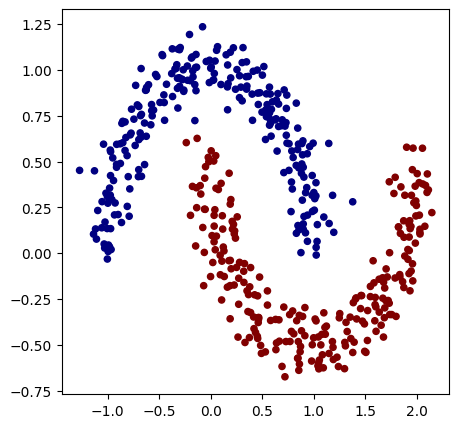

In [23]:
#Using Sklearn.datasets make_moon method to generate some pretty looking "interleaving half circles"
#Added some noise to make it less trivial
X,y = make_moons(n_samples = 500, noise = 0.10)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [30]:
#Let's figure out the shape of our input data and design our MLP from this.

print(X.shape)

#Two dimensional input. 

(500, 2)


In [42]:
#creating an instance of our homemade MLP class with 2 input neurons, a layer with 5 neurons, and another layer with 3 neurons, with 1 output neuron
n = MLP(2,[16,16,1])


In [43]:
for k in range(20):
    #Forward pass
    ypred = [n(x) for x in X]
    loss = sum(((yout - ygt)**2 for ygt,yout in zip(y,ypred)),Value(0))
    #Now we do the backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #Update. now we do gradient descent
    ##Changing the data of each of our parameters depending on the gradient they have on the loss function. Gradient descent! 
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k,loss.data) 

0 990.8966611882553
1 438.5882853846485
2 660.6415261436432
3 350.3035743263168
4 343.95019465639825
5 572.1514199211329
6 416.612215472545
7 378.25325510361756
8 326.9837646349627
9 269.059965413762
10 420.0082226694782
11 396.5268600653619
12 596.7943929438167
13 357.7257155726244
14 308.4813340368013
15 297.12291345179466
16 279.95707412551684
17 278.44369674413076
18 280.000285499288
19 279.666072794819


In [44]:
#draw_dot(loss)